# Advanced Development

Previously we have added new compartments to the model. They were pretty simple modification. Now if we want more realistic model, we may need more complicated modifications, such as:

1. Lockdowns.
2. Death by insufficient healthcare.
3. Death rate by groups.
4. Reinfection.
5. Seasonality.

However we will not be implementing the last two, because they're overkills, because:
1. While there have been reports of reinfection, they are very little so it's not worth the trouble.
2. It is hard to model seasonality for new diseases due to lack of data and understanding. Also it's generally insignificant for areas around the equator.

Let's first init

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import mpld3
mpld3.enable_notebook()

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(13, 8))  
plt.rc('lines', linewidth=2)  

And copy things from previous model

In [4]:
def dpseicrd(y, t, population, exposed_rate, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance):
    population, susceptible, exposed, infectious, critical, recovered, dead = y
    exposed_flow = exposed_rate * susceptible * infectious / population
    infectious_flow = infectious_rate * exposed * 1
    critical_flow = critical_rate * infectious * critical_chance
    recovery_flow_normal = recovery_rate_normal * infectious * (1-critical_chance)
    recovery_flow_critical = recovery_rate_critical * critical * (1-death_chance)
    death_flow = death_rate * critical * death_chance
    dSdt = -exposed_flow
    dEdt = exposed_flow - infectious_flow
    dIdt = infectious_flow - recovery_flow_normal - critical_flow
    dCdt = critical_flow - recovery_flow_critical - death_flow
    dRdt = recovery_flow_normal + recovery_flow_critical
    dDdt = death_flow
    dPdt = dSdt + dEdt + dIdt + dCdt + dRdt + dDdt
    return dPdt, dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [5]:
def plot_pseicrd(t, population, susceptible, exposed, infectious, critical, recovered, dead):
    fig, ax = plt.subplots(1, 1)
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, critical, 'orange', alpha=0.7, label='Critical')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')
    ax.plot(t, dead, 'black', alpha=0.7, label='Dead')
    ax.plot(t, population, 'grey', alpha=0.7, label='Population')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=7)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show()

In [6]:
population = 1000
exposed_rate = 1.0  # infected person infects 1 other person per day
incubation_period = 5.0 # it requires 5 days before someone can infect others
infectious_rate = 1.0 / incubation_period
recovery_time_normal = 4.0 # infections lasts four days for normal infection
recovery_rate_normal = 1.0 / recovery_time_normal
death_time = 3.0 # dying patients die in 3 days
death_rate = 1.0 / death_time
death_chance = 0.2 #20% patients die
critical_time = 7.0 #people may become critical after a week
critical_rate = 1.0 / critical_time
critical_chance = 0.4 #40% infected will need hospital care
recovery_time_critical = 5.0 # infections lasts 5 days for critical patients
recovery_rate_critical = 1.0 / recovery_time_critical

population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init = population, 999, 1, 0, 0, 0, 0  # initial conditions: one exposed, rest susceptible

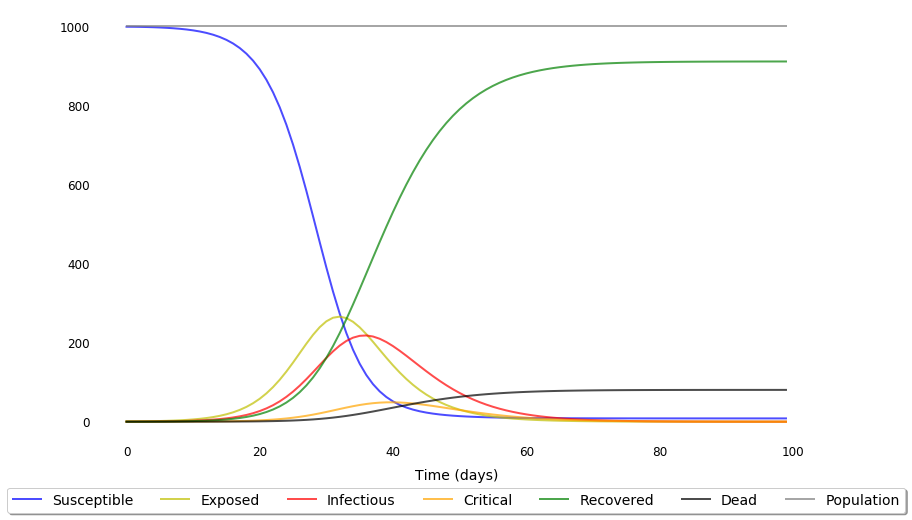

In [7]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd, y0, t, args=(population, exposed_rate, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance))
population_2, susceptible, exposed, infectious, critical, recovered, dead = ret.T
plot_pseicrd(t, population_2, susceptible, exposed, infectious, critical, recovered, dead)

## Lockdowns, time dependent R0

First, let's model lockdowns. Lockdowns can be modelled by making R0, and effectively Beta (the infection rate), a function of time. When lockdown is applied, the infection rate should be reduced because people will be meeting another less often. 

R0 is the basic reproduction number. It's the total number of people one infected will likely infect. 

- R0 = Beta * D
- R0 = infection_rate * recovery_time
- R0 = exposed_rate * recovery_time

If R0 > 1, then the number of the infected will rise exponentially. Having R0 < 1 is sign that the pandemic, or at least that one wave, is ending. 

Although I have no idea why R0 is the independent variable instead of the infection rate.

From that equation, we have:

- infection_rate = R0 / recovery_time
- infection_rate = R0 * recovery_rate

Now let's model the r0. Most region will only do lockdown once or twice. Let's make it just once. R0 will decrease when lockdown is applied, then increase to its previous value when lockdown is lifted.

R0(t) = 
- R0_L if t >= L_start and t < L_end
- R0_0 if t < L_start or t >= L_end

In [8]:
exposed_rate_0 = exposed_rate
r0_0 = exposed_rate_0 * recovery_time_normal
r0_L = 0.5 #let's say the lockdown reduces the R0 to 0.5. That's already very good.
L_start = 30 #Lockdown starts on t=30
L_end = 60 #Lockdown ends on t=60

def r0(t):
    return r0_L if t >= L_start and t < L_end else r0_0

def exposed_rate(t):
    return r0(t) * recovery_rate_normal

That's how it'll be with normal model, or at least up to SEIRD. However, this got more complicated since we added the Critical compartment. The total number an infected may infect may be different because an infectious may be admitted to a hospital before the usual recovery time ends. Let's redo from R0 without lockdown.

- R0 = exposed_rate * recovery_time
- R0 = exposed_rate * (recovery_time_normal * (1-critical_chance) + critical_time * critical_chance)
- infectious_period_opt = recovery_time_normal * (1-critical_chance) + critical_time * critical_chance
- R0 = exposed_rate * recovery_time_opt

And adjust the exposed_rate formula accordingly.

- exposed_rate = R0 / recovery_time_opt

In [9]:
infectious_period_opt = recovery_time_normal * (1-critical_chance) + critical_time * critical_chance

r0_0 = exposed_rate_0 * infectious_period_opt

r0_0

5.2

In [10]:
def exposed_rate(t):
    return r0(t) / infectious_period_opt

Adjust the derivative function to use the new exposed_rate function.

In [11]:
def dpseicrd_r(y, t, population, exposed_rate, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance):
    population, susceptible, exposed, infectious, critical, recovered, dead = y
    exposed_flow = exposed_rate(t) * susceptible * infectious / population
    infectious_flow = infectious_rate * exposed * 1
    critical_flow = critical_rate * infectious * critical_chance
    recovery_flow_normal = recovery_rate_normal * infectious * (1-critical_chance)
    recovery_flow_critical = recovery_rate_critical * critical * (1-death_chance)
    death_flow = death_rate * critical * death_chance
    dSdt = -exposed_flow
    dEdt = exposed_flow - infectious_flow
    dIdt = infectious_flow - recovery_flow_normal - critical_flow
    dCdt = critical_flow - recovery_flow_critical - death_flow
    dRdt = recovery_flow_normal + recovery_flow_critical
    dDdt = death_flow
    dPdt = dSdt + dEdt + dIdt + dCdt + dRdt + dDdt
    return dPdt, dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

Now let's try running it.

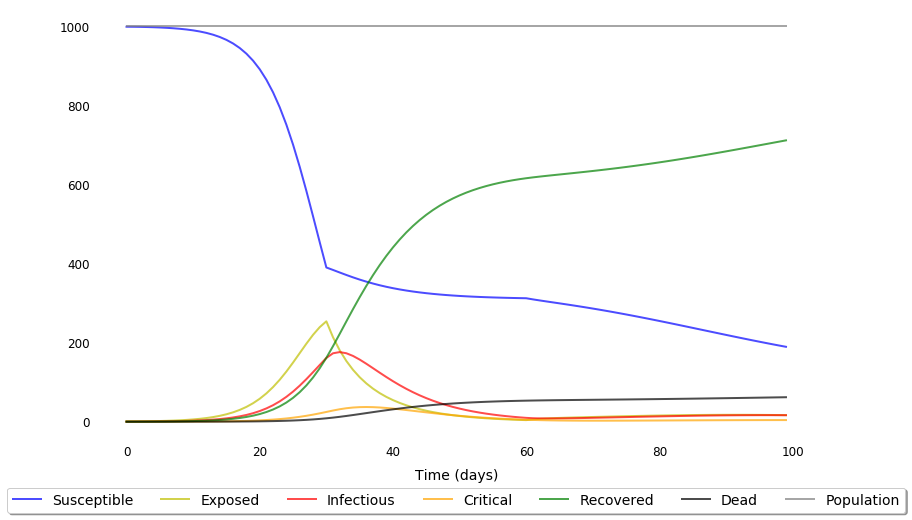

In [12]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd_r, y0, t, args=(population, exposed_rate, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance))
population_2, susceptible, exposed, infectious, critical, recovered, dead = ret.T
plot_pseicrd(t, population_2, susceptible, exposed, infectious, critical, recovered, dead)

Notice the sharp change in t=30? Yes. That's the effect of lockdown, if it's effective. There isn't a sharp change in t=60 because the lockdown was effective. If it wasn't effective, there will be second wave after t=60.

This sharp change is unrealistic though. Let's smoothen it with logistic function. But first, plot the r0.

In [13]:
def map_function(t, f):
    return np.array([f(ti) for ti in t])

In [14]:
def plot_single(t, f, label):
    fig, ax = plt.subplots(1, 1)
    ax.plot(t, map_function(t, f), 'b', alpha=0.7, label=label)

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=7)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show()

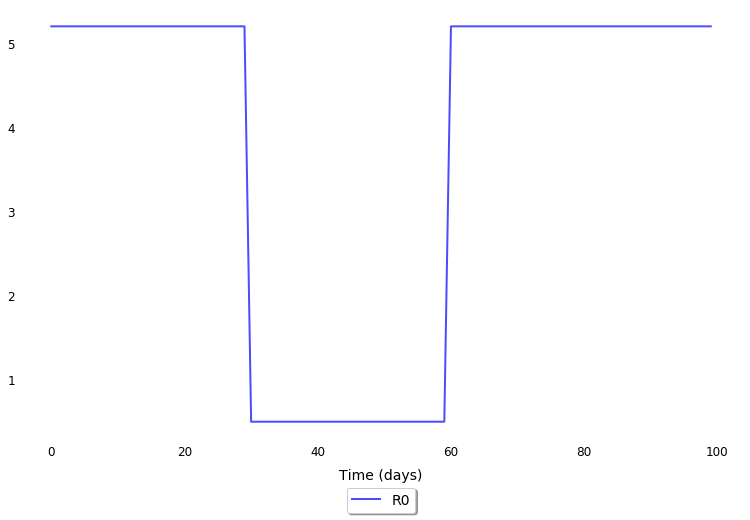

In [15]:
plot_single(t, r0, "R0")

We'll start with the lockdown start first.

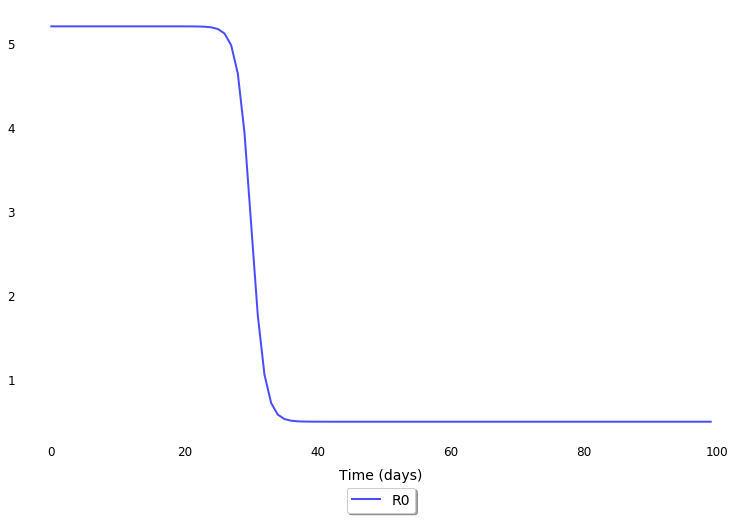

In [16]:
r0_delta = r0_0 - r0_L
k = 1
def logistic_r0(t):
    return r0_delta / (1 + np.exp(-k*(-t+L_start))) + r0_L
plot_single(t, logistic_r0, "R0")

Smooth, but that's not quite it. It should start decreasing at t=30, not before. We should give an offset that is tied to k. 

But, man, it's hard. Let's leave it at this. Let's just apply the R0 increase.

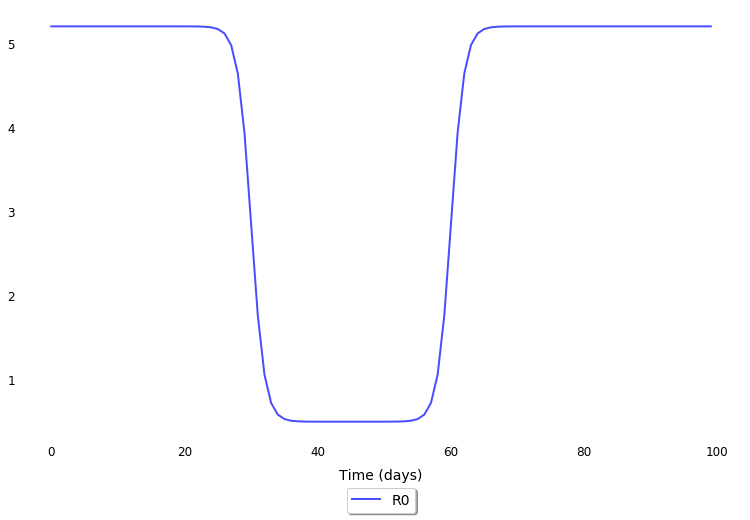

In [23]:
def logistic_r0(t):
    e1 = np.exp(k*(-t+L_start))
    e2 = np.exp(k*(-t+L_end))
    return r0_0 + (r0_L-r0_0) / (1 + e1) + (r0_0-r0_L) / (1 + e2)
plot_single(t, logistic_r0, "R0")

There we go. Now the exposed_rate, and plot

In [48]:
def exposed_rate_logistic(t):
    return logistic_r0(t) / infectious_period_opt

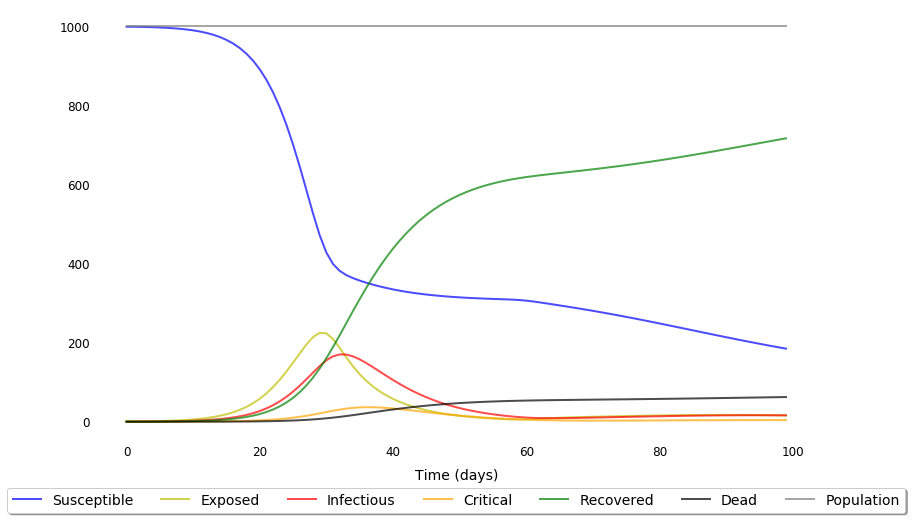

In [49]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd_r, y0, t, args=(population, exposed_rate_logistic, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance))
population_2, susceptible, exposed, infectious, critical, recovered, dead = ret.T
plot_pseicrd(t, population_2, susceptible, exposed, infectious, critical, recovered, dead)

Nice curves, eh?

# Death by Insufficient Healthcare

Next is death by insufficient health care. Those not receiving health care will most likely die, so let's just make the death chance 1. However, its death rate might not be the same as the ones receiving health care. This will modify some transitions:

- critical_cared = min(critical, critical_limit)
- critical_over = max(0, critical-critical_limit)

- C->R : recovery_rate * critical_cared * (1-death_chance_normal)
- C->D normal : death_rate_normal * critical_cared * death_chance_normal
- C->D over : death_rate_over * critical_over * death_chance_over

In [82]:
critical_limit = 20 #limit of hospital bed. only 20 since critical is small in our modelexposed_rate_crit = 2.0
death_time_normal = death_time
death_time_over = 2
death_rate_normal = death_rate
death_rate_over = 1/death_time_over
death_chance_normal = death_chance
death_chance_over = 1 #criticals not receiving health care will surely die

But! Still not that simple. The limit of critical patients will rise as time goes, because more rooms will be prepared and maybe even hospitals! The critical_limit should be a function of time. However the rise of critical_limit is not continuous. Maybe at day 40 the government decided to add 30 rooms, then stay silent until they add more at day 80. This should be an array then.

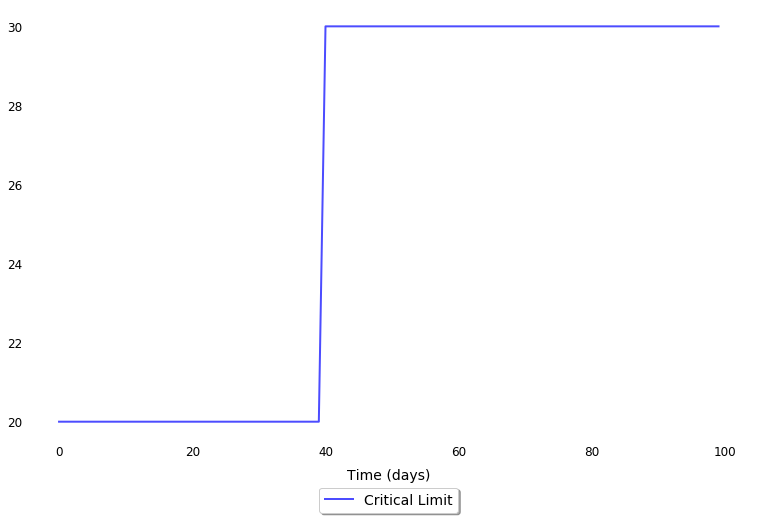

In [83]:
critical_limit_data = [
    (0, 20),
    (40, 30)
]
def critical_limit(t):
    ret = float("inf")
    for day, limit in critical_limit_data:
        if day <= t:
            ret = limit
        else:
            break
    return ret

plot_single(t, critical_limit, "Critical Limit")

Lastly, criticals not receiving healthcare means they are not being isolated in hospital. This means that they can infect other people, such as their family and nurse (which might not be actual nurse). The infection rate should be different too, because (1) they are way more severe and (2) they dont get to meet much people.

- S->E normal : exposed_rate_normal * susceptible * infectious/population 
- S->E over : exposed_rate_crit * susceptible * critical_over/population
- S->E : exposed_rate_normal * susceptible * infectious/population + exposed_rate_crit * susceptible * critical_over/population
- S->E : susceptible * (exposed_rate_normal * infectious + exposed_rate_crit * critical_over) / population

In [101]:
exposed_rate_critical = 2.0

There are more infection flows now. Should this affect our already complicated time dependent R0? Not really. Why? Because:
1. The infection from over critical people uses different rate
2. Lockdowns don't affect those critical people who can barely move

However, the overall R0 still should be recalculated. the time.

- infectious_period_opt = recovery_time_normal * (1-critical_chance) + critical_time * critical_chance
- r0_0 = exposed_rate_0 * infectious_period_opt
- exposed_rate_opt(t): r0(t) / infectious_period_opt
- r0_over(critical_over) = exposed_rate_critical * death_time_over * critical_chance * (critical_over/population)
- r0_overall(t, critical_over): r0(t) + r0_over(critical_over)

- R0 = exposed_rate * recovery_time
- R0 = exposed_rate * (recovery_time_normal * (1-critical_chance) + recovery_time_critical * critical_chance)
- R0 = exposed_rate_normal * (recovery_time_normal * (1-critical_chance) + recovery_time_critical * critical_chance)
- R0 = exposed_rate_normal * recovery_time_normal * (1-critical_chance) + exposed_rate_normal * recovery_time_critical * critical_chance

In [120]:
def r0_over(critical_over):
    return exposed_rate_critical * death_time_over * critical_chance * (critical_over/population)
def r0_overall(t, critical_over):
    return logistic_r0(t) + r0_over(critical_over)

Now we modify the derivative function. Let's first list the variables.

- critical_cared = min(critical, critical_limit)
- critical_over = max(0, critical-critical_limit)

And the flow changes.
- C->R : recovery_rate * critical_cared * (1-death_chance_normal)
- C->D normal : death_rate_normal * critical_cared * death_chance_normal
- C->D over : death_rate_over * critical_over * death_chance_over
- S->E normal : exposed_rate_normal * susceptible * infectious/population 
- S->E over : exposed_rate_crit * susceptible * critical_over/population

In [104]:
def dpseicrd_rl(y, t, population, 
                exposed_rate_normal, exposed_rate_critical, infectious_rate, 
                critical_rate, critical_chance, 
                recovery_rate_normal, recovery_rate_critical, 
                critical_limit, 
                death_rate_normal, death_chance_normal, 
                death_rate_over, death_chance_over):
    
    population, susceptible, exposed, infectious, critical, recovered, dead = y
    
    critical_cared = min(critical, critical_limit(t))
    critical_over = max(0, critical-critical_limit(t))
    
    exposed_flow_normal = exposed_rate_normal(t) * susceptible * infectious / population
    exposed_flow_over = exposed_rate_critical * susceptible * critical_over / population
    exposed_flow = exposed_flow_normal + exposed_flow_over
    
    infectious_flow = infectious_rate * exposed * 1
    critical_flow = critical_rate * infectious * critical_chance
    recovery_flow_normal = recovery_rate_normal * infectious * (1-critical_chance)
    
    recovery_flow_critical = recovery_rate_critical * critical_cared * (1-death_chance_normal)
    
    death_flow_normal = death_rate_normal * critical_cared * death_chance_normal
    death_flow_over = death_rate_over * critical_over * death_chance_over
    death_flow = death_flow_normal + death_flow_over
    
    
    dSdt = -exposed_flow
    dEdt = exposed_flow - infectious_flow
    dIdt = infectious_flow - recovery_flow_normal - critical_flow
    dCdt = critical_flow - recovery_flow_critical - death_flow
    dRdt = recovery_flow_normal + recovery_flow_critical
    dDdt = death_flow
    dPdt = dSdt + dEdt + dIdt + dCdt + dRdt + dDdt
    
    return dPdt, dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

Add the critical limit to the plot

In [105]:
def plot_pseicrd_l(t, population, susceptible, exposed, infectious, critical, recovered, dead, critical_limit):
    fig, ax = plt.subplots(1, 1)
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, critical, 'orange', alpha=0.7, label='Critical')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')
    ax.plot(t, dead, 'black', alpha=0.7, label='Dead')
    ax.plot(t, population, 'grey', alpha=0.3, label='Population', ls='dotted')
    ax.plot(t, critical_limit, 'red', alpha=0.3, label='Healthcare', ls='dotted')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=8)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show()

Let's first review the previous model but with critical limit plot

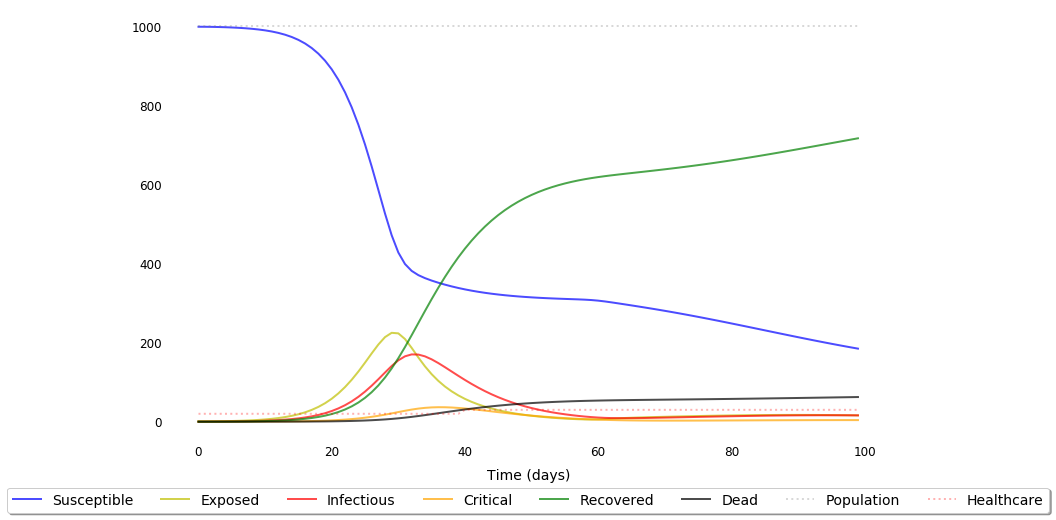

In [107]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd_r, y0, t, args=(
    population, exposed_rate_logistic, infectious_rate, 
    critical_rate, critical_chance, 
    recovery_rate_normal, recovery_rate_critical,
    death_rate_normal, death_chance_normal
))
population_2, susceptible, exposed, infectious, critical, recovered, dead = ret.T
plot_pseicrd_l(t, population_2, susceptible, exposed, infectious, critical, recovered, dead, map_function(t, critical_limit))

The critical curve is quite above the critical limit, while the dead curve doesn't exceed 100. Now, for the new model:

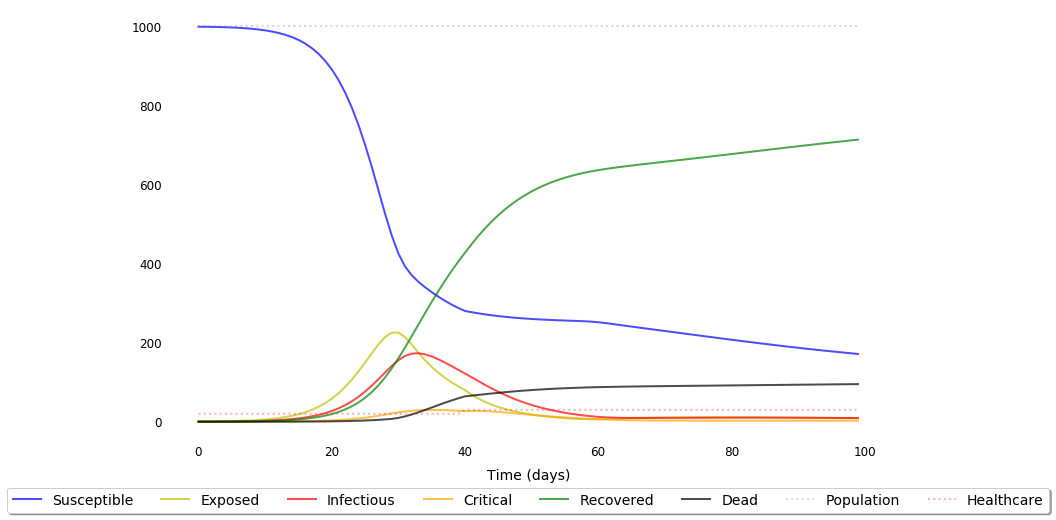

In [108]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd_rl, y0, t, args=(
    population, exposed_rate_logistic, exposed_rate_critical, infectious_rate, 
    critical_rate, critical_chance, 
    recovery_rate_normal, recovery_rate_critical, 
    critical_limit, 
    death_rate_normal, death_chance_normal,
    death_rate_over, death_chance_over
))
population_2, susceptible, exposed, infectious, critical, recovered, dead = ret.T
plot_pseicrd_l(t, population_2, susceptible, exposed, infectious, critical, recovered, dead, map_function(t, critical_limit))

See how the critical is quite flat now? And how the dead count is now almost 100? This is what was happening in Italy. The critical patients exceed the healthcare capacity so doctors have to choose who gets the chance to live and who doesn't. Generally, the old ones are sacrificed for the young

## More Insight

That was good enough. But I may want to see more from the plot. For example, I'd like details specific to the effects from insufficient healthcare, to know how many can be saved if the healthcare is sufficient. We'll need to modify both the derivative function and the plotting function. Previously, this mechanism affects the exposed flow and the dead flow. Aside from the criticals, we'll also have to split them both. Might as well make the critical_over a new compartment.

- CC->CO : 1 * min(critical_limit, critical_cared) * 1
- CO->CC : 1 * max(0, critical_limit - critical_over+critical_cared) * 1
- CC->R : recovery_rate_critical * critical_cared * (1-death_chance_normal)
- CC->DN : death_rate_normal * critical_cared * death_chance_normal
- CO->DO : death_rate_over * critical_over * death_chance_critical

- S->EN : exposed_rate_normal(t) * susceptible * infectious / population
- S->EO : exposed_rate_crit * susceptible * critical_over / population
- EO->I : infectious_rate * exposed_normal * 1
- EI->I : infectious_rate * exposed_over * 1

In [153]:
def dpseicrd_rl_ext(y, t, population, 
                exposed_rate_normal, exposed_rate_critical, infectious_rate, 
                critical_rate, critical_chance, 
                recovery_rate_normal, recovery_rate_critical, 
                critical_limit, 
                death_rate_normal, death_chance_normal, 
                death_rate_over, death_chance_over):
    
    population, susceptible, exposed_normal, exposed_over, infectious, critical_cared, critical_over, recovered, dead_normal, dead_over = y
    
    
    exposed_flow_normal = exposed_rate_normal(t) * susceptible * infectious / population
    exposed_flow_over = exposed_rate_critical * susceptible * critical_over / population
    
    infectious_flow_normal = infectious_rate * exposed_normal * 1
    infectious_flow_over = infectious_rate * exposed_over * 1
    
    recovery_flow_normal = recovery_rate_normal * infectious * (1-critical_chance)
    recovery_flow_critical = recovery_rate_critical * critical_cared * (1-death_chance_normal)
    
    death_flow_normal = death_rate_normal * critical_cared * death_chance_normal
    death_flow_over = death_rate_over * critical_over * death_chance_over
    
    #tricky part because it should be immediate
    
    #recovering or dying people will free up available care
    available_care = critical_limit(t) - critical_cared + recovery_flow_critical + death_flow_normal
    if available_care < 0:
        raise Exception("available_care should never be negative")
    
    #overflow applying for hospital should take precedence
    #well it's not like it will matter in numbers since new critical people will take their place here
    
    critical_over_return = 1 * min(available_care, critical_over) * 1
    
    available_care_2 = available_care - critical_over_return
    if available_care_2 < 0:
        raise Exception("available_care_2 should never be negative")
    
    #next, the new criticals will flow in
    
    critical_flow = critical_rate * infectious * critical_chance
    critical_flow_cared = min(available_care_2, critical_flow)
    
    available_care_3 = available_care_2 - critical_flow_cared
    if available_care_3 < 0:
        raise Exception("available_care_3 should never be negative")
    
    #the remains of that flow will go to over compartment
    critical_flow_over = critical_flow - critical_flow_cared
    
    dSdt = -exposed_flow_normal - exposed_flow_over
    dENdt = exposed_flow_normal - infectious_flow_normal
    dEOdt = exposed_flow_over - infectious_flow_over
    dIdt = infectious_flow_normal + infectious_flow_over - recovery_flow_normal - critical_flow_cared - critical_flow_over
    dCCdt = critical_flow_cared + critical_over_return - recovery_flow_critical - death_flow_normal
    dCOdt = critical_flow_over - death_flow_over - critical_over_return
    dRdt = recovery_flow_normal + recovery_flow_critical
    dDNdt = death_flow_normal
    dDOdt = death_flow_over
    dPdt = dSdt + dENdt + dEOdt + dIdt + dCCdt + dCOdt + dRdt + dDNdt + dDOdt
    
    return dPdt, dSdt, dENdt, dEOdt, dIdt, dCCdt, dCOdt, dRdt, dDNdt, dDOdt

In [154]:
from operator import add
def sum_element(a, b):
    return np.array(list(map(add, a, b)))

In [155]:
def delta(arr):
    return np.array([arr[0]] + [arr[i]-arr[i-1] for i in range(1, len(arr))])

In [167]:
def plot_pseicrd_l_ext(t, population, 
                       susceptible, exposed_normal, exposed_over, infectious, 
                       critical_cared, critical_over, recovered, 
                       dead_normal, dead_over, critical_limit):
    fig, ax = plt.subplots(1, 1)
    
    #totals
    exposed = sum_element(exposed_normal, exposed_over)
    critical = sum_element(critical_cared, critical_over)
    dead = sum_element(dead_normal, dead_over)
    
    
    #main plot
    
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, critical, 'orange', alpha=0.7, label='Critical')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')
    ax.plot(t, dead, 'black', alpha=0.7, label='Dead')
    ax.plot(t, population, 'grey', alpha=0.3, label='Population', ls='dotted')
    ax.plot(t, critical_limit, 'red', alpha=0.3, label='Healthcare', ls='dotted')
    
    ax.title.set_text('SEICRD')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='best', shadow=True)
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # R0
    
    fig2, ax2 = plt.subplots(1, 1)
    ax2.plot(t, map_function(t, logistic_r0), 'y', alpha=0.5, linewidth=2, label='R0 normal')
    ax2.plot(t, map_function(critical_over, r0_over), 'r', alpha=0.5, linewidth=2, label='R0 over')
    r0_overall_val = np.array([r0_overall(t[i], critical_over[i]) for i in range(0, len(t))])
    ax2.plot(t, r0_overall_val, 'orange', alpha=0.7, linewidth=2, label='R0 overall')

    ax2.title.set_text('R0 over time')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax2.spines[spine].set_visible(False)
        
        
    # over cases only
    
    fig3, ax3 = plt.subplots(1, 1)
    ax3.plot(t, exposed_over, 'blue', alpha=0.7, linewidth=2, label='Exposed by Neglected')
    ax3.plot(t, critical_over, 'orange', alpha=0.7, linewidth=2, label="Critical but Neglected")
    ax3.plot(t, dead_over, 'black', alpha=0.7, linewidth=2, label='Dead by Neglect')

    ax3.title.set_text('Insufficient Healthcare')
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax3.spines[spine].set_visible(False)
    
    #death chance
    
    # sp2
    death_chance_calc = [0] + [100 * dead[i] / sum(infectious_rate*exposed[:i]) if sum(infectious_rate*exposed[:i])>0 else 0 for i in range(1, len(t))]
    
    fig4, ax4 = plt.subplots(1, 1)
    ax4.plot(t, death_chance_calc, 'blue', alpha=0.7, linewidth=2, label='Death Chance')

    ax4.title.set_text('Insufficient Healthcare')
    ax4.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax4.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax4.spines[spine].set_visible(False)
        
    #daily seicrd
    fig5, ax5 = plt.subplots(1, 1)
    
    daily_exposed = delta(exposed)
    daily_infectious = delta(infectious)
    daily_critical = delta(critical)
    daily_recovered = delta(recovered)
    daily_dead = delta(dead)
    
    ax5.plot(t, daily_exposed, 'y', alpha=0.7, label='Exposed')
    ax5.plot(t, daily_infectious, 'r', alpha=0.7, label='Infectious')
    ax5.plot(t, daily_critical, 'orange', alpha=0.7, label='Critical')
    ax5.plot(t, daily_recovered, 'g', alpha=0.7, label='Recovered')
    ax5.plot(t, daily_dead, 'black', alpha=0.7, label='Dead')
    ax5.plot(t, critical_limit, 'red', alpha=0.3, label='Healthcare', ls='dotted')
    
    ax5.title.set_text('Daily SEICRD')

    ax5.set_xlabel('Time (days)', labelpad=10)

    ax5.yaxis.set_tick_params(length=0)
    ax5.xaxis.set_tick_params(length=0)

    ax5.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax5.legend(loc='best', shadow=True)
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax5.spines[spine].set_visible(False)
    
    
        
    # healthcare limit
    
    fig6, ax6 = plt.subplots(1, 1)
    ax6.plot(t, critical_cared, 'blue', alpha=0.7, linewidth=2, label='Critical cared')
    ax6.plot(t, critical_limit, 'orange', alpha=0.7, linewidth=2, label="Healthcare Limit")

    ax6.title.set_text('Healthcare limit')
    ax6.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax6.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax6.spines[spine].set_visible(False)
    
    plt.show()

In [168]:
population_init, susceptible_init, exposed_normal_init, exposed_over_init, infectious_init, critical_cared_init, critical_over_init, recovered_init, dead_normal_init, dead_over_init = population, 999, 1, 0, 0, 0, 0, 0, 0, 0  # initial conditions: one exposed, rest susceptible

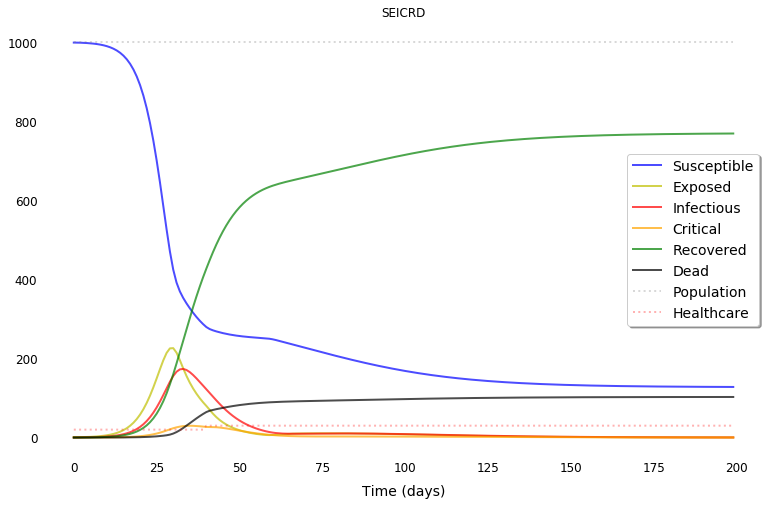

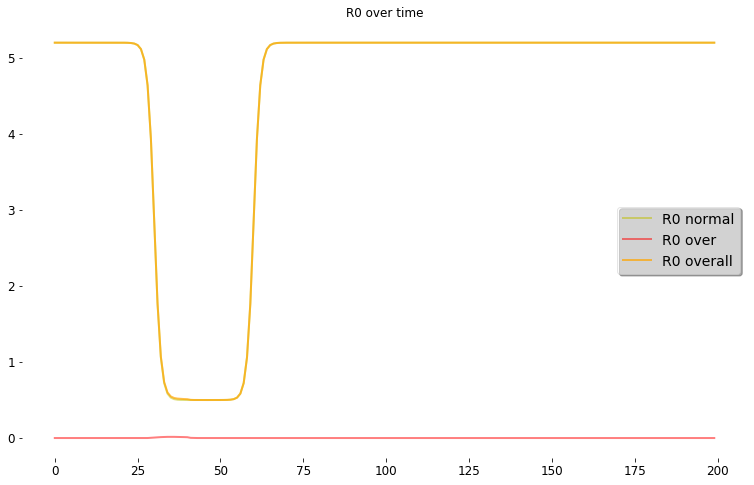

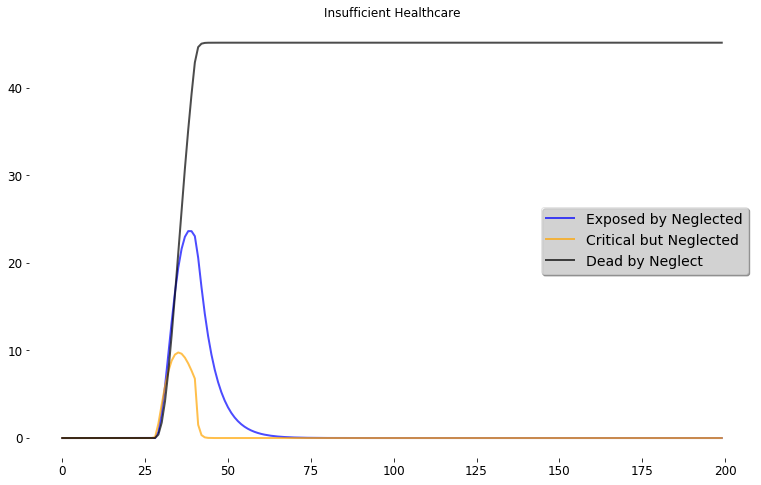

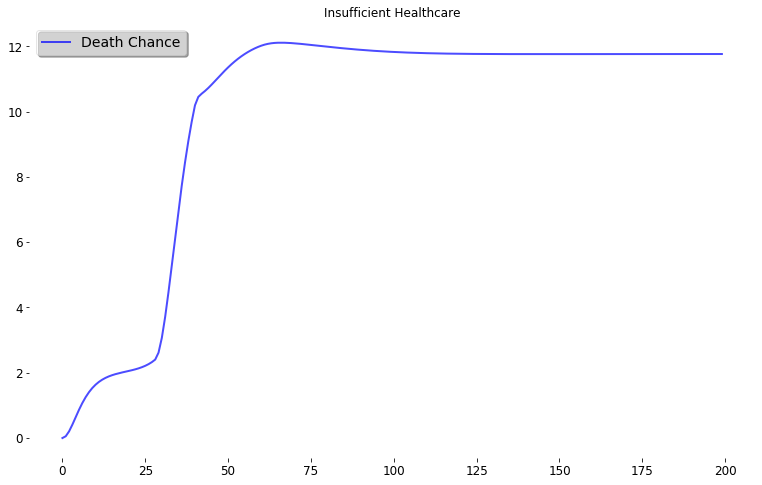

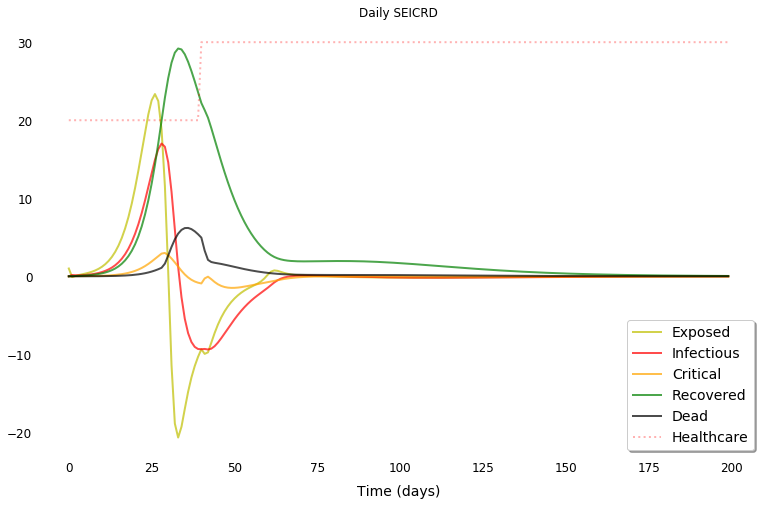

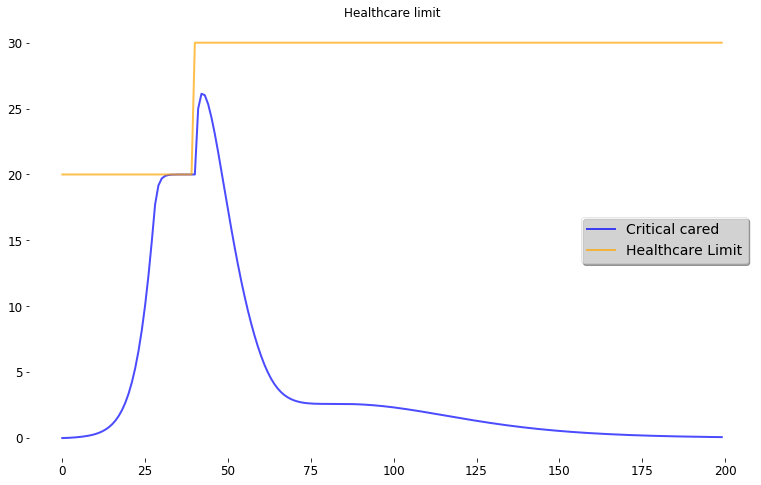

In [169]:
t = np.linspace(0, 199, 200) # 200 days
y0 = population_init, susceptible_init, exposed_normal_init, exposed_over_init, infectious_init, critical_cared_init, critical_over_init, recovered_init, dead_normal_init, dead_over_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd_rl_ext, y0, t, args=(
    population, exposed_rate_logistic, exposed_rate_critical, infectious_rate, 
    critical_rate, critical_chance, 
    recovery_rate_normal, recovery_rate_critical, 
    critical_limit, 
    death_rate_normal, death_chance_normal,
    death_rate_over, death_chance_over
))
population_2, susceptible, exposed_normal, exposed_over, infectious,  critical_cared, critical_over, recovered,  dead_normal, dead_over = ret.T
plot_pseicrd_l_ext(t, population_2, susceptible, 
               exposed_normal, exposed_over, infectious, 
               critical_cared, critical_over, recovered, 
               dead_normal, dead_over, map_function(t, critical_limit))

## Death Rate by Groups

It is common knowledge that old people are more vulnerable. Therefore, a population with mostly old people should be more vulnerable than the a population with mostly young people. If your rates and chances are global or general, you may need to tweak it to better fit the population. However, this requires more data.

For example, we have this death chance by age here. We also have two populations. The first population mostly consists of old people, while the second consists mostly of young people.

In [159]:
death_chance_age = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
population_age_1 = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
population_age_2 = {"0-29": 0.4, "30-59": 0.4, "60-89": 0.15, "89+": 0.05}

The calculation is quite easy. We just calculate the dot product of the two dictionaries. 

In [160]:
def fit_group_values(value, population):
    return sum(value[i] * population[i] for i in population.keys())

The first population has effective death chance of 15.6%

In [161]:
fit_group_values(death_chance_age, population_age_1)

0.15600000000000003

While the second population has effective death chance of 6.9%

In [162]:
fit_group_values(death_chance_age, population_age_2)

0.069

The difference is significant. However, in the end your model depends on your data. If your death chance is already specific for that population, this isn't needed. Else, you will need those two data; death chance by age and the age proportion in that population. Are they available?

This concludes the advanced development notebook.